In [ ]:
import numpy as np
import pandas as pd
import cv2
import re 
import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.autonotebook import trange
from pathlib import Path
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms, models
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Описание датасета и подготовка данных к обучению.

**Описание датасета ESC-50.**

Данный датасет содержит 2000 звуковых дорожек, включающих 50 классов различных звуков, а именно:

*   Животные 
  *   Собака	
  *   Петух
  *   Свинья
  *   Корова
  *   Лягушка
  *   Кошка 
  *   Курица 
  *   Насекомые (летающие) 
  *   Овца
  *   Ворона 

*   Звуки природы и воды
  *   Дождь	
  *   Морские волны 
  *   Потрескивание огня 
  *   Сверчки
  *   Щебетание птиц
  *   Капли воды 
  *   Ветер 
  *   Наливание воды 
  *   Смыв в туалете
  *   Гроза 

*   Неречевые звуки человека
  *   Плач ребенка	
  *   Чихание 
  *   Хлопанье 
  *   Дыхание
  *   Кашель 
  *   Шаги 
  *   Смех 
  *   Чистка зубов 
  *   Храп 
  *   Питье, потягивание 

*   Интерьер и домашние звуки
  *   Стук двери	
  *   Щелчок мыши 
  *   Набор текста с клавиатуры
  *   Дверь, скрип дерева 
  *   Открывание консервной банки 
  *   Стиральная машина
  *   Пылесос 
  *   Будильник 
  *   Тиканье часов 
  *   Разбивание стекла 

*   Внешние и городские шумы
  *   Вертолет
  *   Бензопила
  *   Сирена
  *   Автомобильный гудок
  *   Двигатель
  *   Поезд
  *   Церковные колокола
  *   Самолет
  *   Фейерверк
  *   Ручная пила






**Загрузка датасета ESC-50.**

In [ ]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip   #Скачивание

--2022-09-11 07:00:46--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2022-09-11 07:00:46--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2022-09-11 07:00:47--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip            

In [ ]:
%%capture
!unzip master.zip   # Распаковка.

**Содержимое папки ESC-50-master:**

> audio/*.wav 

  2000 аудиозаписей в формате WAV (5 секунд, 44,1 кГц, mono) со следующим соглашением об именах:

{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav
    
*   {FOLD}- индекс перекрестной проверки кратности,
*   {CLIP_ID}- ID оригинального клипа Freesound,
*   {TAKE}- буква, устраняющая неоднозначность между разными фрагментами из одного и того же клипа Freesound,
*   {TARGET}- класс в числовом формате [0, 49].

> meta/esc50.csv

CSV-файл со следующей структурой:

*   имя файла		
*   подкласса (1 из 5)
*   номер класса
*   имя класаа
*   esc10	
*   src_file	
*   take

В esc10столбце указано, принадлежит ли данный файл подмножеству ESC-10 (10 выбранных классов, лицензия CC BY).

> meta/esc50-human.xlsx

Дополнительные данные, относящиеся к краудсорсинговому эксперименту (точность человеческой классификации).

С помощью модуля IPython можно послушать любую из дорожек, прописав путь к ней.

In [ ]:
import IPython

IPython.display.Audio('/content/ESC-50-master/audio/1-100032-A-0.wav')

Установим **соответствия между номером класса и его названием** в виде словаря в формате {номер класса: имя класса}.

Для этого считывем файл esc50.csv с помощью блиотеки pandas. В колонке target находится значение класса в числовом формате, а в колонке category - имя класса.


In [ ]:
esc50_csv = pd.read_csv('/content/ESC-50-master/meta/esc50.csv')
esc50_csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Используем groupby() для получения пар (номер класса - имя класса).

In [ ]:
num_name_df = esc50_csv.groupby(['target'])['category'].unique()

In [ ]:
num_name_dict = {}
for num_class, name_class in zip(num_name_df.index, num_name_df):
    num_name_dict[num_class] = name_class[0] 

In [ ]:
#%pprint
num_name_dict

{0: 'dog',
 1: 'rooster',
 2: 'pig',
 3: 'cow',
 4: 'frog',
 5: 'cat',
 6: 'hen',
 7: 'insects',
 8: 'sheep',
 9: 'crow',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 13: 'crickets',
 14: 'chirping_birds',
 15: 'water_drops',
 16: 'wind',
 17: 'pouring_water',
 18: 'toilet_flush',
 19: 'thunderstorm',
 20: 'crying_baby',
 21: 'sneezing',
 22: 'clapping',
 23: 'breathing',
 24: 'coughing',
 25: 'footsteps',
 26: 'laughing',
 27: 'brushing_teeth',
 28: 'snoring',
 29: 'drinking_sipping',
 30: 'door_wood_knock',
 31: 'mouse_click',
 32: 'keyboard_typing',
 33: 'door_wood_creaks',
 34: 'can_opening',
 35: 'washing_machine',
 36: 'vacuum_cleaner',
 37: 'clock_alarm',
 38: 'clock_tick',
 39: 'glass_breaking',
 40: 'helicopter',
 41: 'chainsaw',
 42: 'siren',
 43: 'car_horn',
 44: 'engine',
 45: 'train',
 46: 'church_bells',
 47: 'airplane',
 48: 'fireworks',
 49: 'hand_saw'}

Проверим нет ли дисбаланса классов.

In [ ]:
esc50_csv.target.value_counts()

0     40
39    40
29    40
10    40
7     40
26    40
6     40
44    40
23    40
20    40
49    40
24    40
28    40
14    40
18    40
2     40
35    40
38    40
21    40
1     40
11    40
42    40
5     40
33    40
40    40
12    40
43    40
27    40
36    40
19    40
30    40
34    40
9     40
22    40
48    40
41    40
47    40
31    40
17    40
45    40
8     40
15    40
46    40
37    40
32    40
16    40
25    40
4     40
3     40
13    40
Name: target, dtype: int64

В каждом классе по 40 экземпляров. Дисбаланса классов нет.

Теперь **загрузим все дорожки.**

In [ ]:
directory = Path('/content/ESC-50-master/audio')  # Путь к папке с файлами

In [ ]:
data_files = sorted(list(directory.rglob('*.wav'))) # Путь к каждому файлу

Из имени файла получим численную метку класса.

In [ ]:
y = []
for fil in data_files:
    y.append(int(re.search(r'\d{1,2}', (str(fil)[-6:-4]))[0]))

Теперь создадим датафрейм с двумя колонками: путь к файлу | метка класса.

In [ ]:
df = pd.DataFrame(list(zip(data_files, y)), columns = ['path', 'target']) 
df.head()

,path,target
0,/content/ESC-50-master/audio/1-100032-A-0.wav,0
1,/content/ESC-50-master/audio/1-100038-A-14.wav,14
2,/content/ESC-50-master/audio/1-100210-A-36.wav,36
3,/content/ESC-50-master/audio/1-100210-B-36.wav,36
4,/content/ESC-50-master/audio/1-101296-A-19.wav,19


Файлы *.wav представляют собой набор амплитуд, отсчитываемых за определенные промежутки времени. Построим график амплитуд для первых трёх звукозаписей:

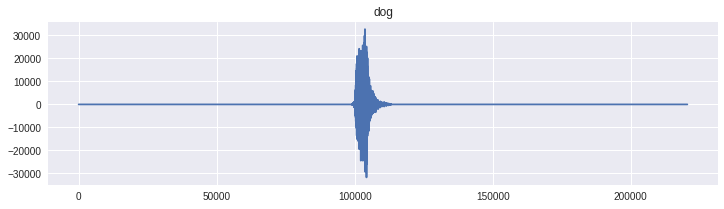

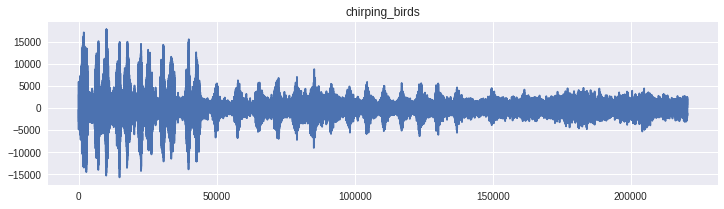

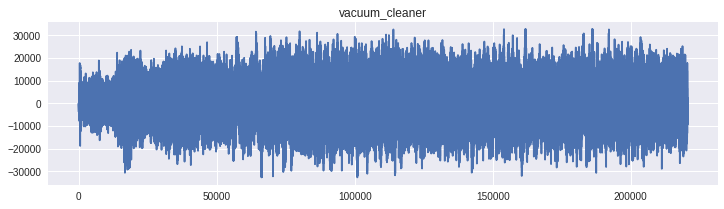

In [ ]:
plt.style.use('seaborn')
for file_ in data_files[:3]:
    X = wavfile.read(file_)[1]
    y = int(re.search(r'\d{1,2}', (str(file_)[-6:-4]))[0])
    plt.figure(figsize=(12,3))
    plt.plot(X)
    plt.title(num_name_dict[y])

Из графиков видно, что одна дорожка содержит около 200 000 точек. Работать с такими данными будет неудобно, поэтому лучше конвертировать в изображение.

Создадим класс, который будет из файлов *.wav получать мел-спектрограммы, а потом конвертировать их в изображение.

In [ ]:
class ESCDataset(Dataset):
    def __init__(self, df, img_size=224, mode='train', melspectrogram_params={}):
        self.img_size = img_size
        self.melspectrogram_params = melspectrogram_params
        self.files = np.array(df['path'])
        self.mode = mode
        # Получение меток класса
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.y = np.array(df['target'])
            self.label_encoder.fit(self.y)
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        #transform = transforms.Compose([transforms.ToTensor()])
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])  # Такая нормализация необходима при использовании ResNet
        eps = 1e-6

        # Получение спектра
        sound, sr  = librosa.load(self.files[index], sr=None)
        spec = librosa.feature.melspectrogram(sound, sr=sr, **self.melspectrogram_params) 
        spec = librosa.power_to_db(spec).astype(np.float32)

        # Нормализация [0, 255]
        spec = np.stack([spec, spec, spec], axis=-1)
        spec_norm = (spec - spec.mean()) / (spec.std() + eps)
        spec_scaled = 255 * (spec_norm - spec_norm.min()) / (spec_norm.max() - spec_norm.min()) 

        # Получение картинки
        X = spec_scaled.astype(np.uint8)
        height, width, _ = X.shape
        X = cv2.resize(X, (int(width * self.img_size / height), self.img_size))
        #X = X.resize((self.img_size, self.img_size))
        X = (X / 255.0).astype(np.float32)
        X = transform(X)

        if self.mode == 'test':
            return X
        else:
            y = self.y[index]
            y_id = self.label_encoder.transform([y])
            y = y_id.item()
            return X, y

Разобьём данные на тренировочные и тестовые.

In [ ]:
files_train, files_test = train_test_split(df, train_size = 0.9, random_state = 2022)

Теперь разобьём их на тренировочную  и валидационную выборки.

In [ ]:
files_train, files_val = train_test_split(files_train, train_size = 0.8, random_state = 2022)

Зададим параметры для мел-спектрограммы.

In [ ]:
melspectrogram_parameters = {
    'n_fft':2048, 
    'hop_length':512,
    'n_mels': 128
    }

И получим спектрограммы.

In [ ]:
train_dataset = ESCDataset(files_train, mode='train', melspectrogram_params=melspectrogram_parameters)
val_dataset = ESCDataset(files_val, mode='val', melspectrogram_params=melspectrogram_parameters)
test_dataset = ESCDataset(files_test, mode='test', melspectrogram_params=melspectrogram_parameters)   

Создаём даталоудеры. Тренировочные данные перемешиваем, а валидационные  - нет.

In [ ]:
# DataLoader
BATCH_SIZE = 128
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset)}

# Обучение модели.

Проверяем возможность использования GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = torch.cuda.is_available()
print(f'Using {device} mode')

Using cpu mode


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):

    best_model_wts = model.state_dict()
    best_f1 = 0.0
    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")
    for epoch in pbar:
        for phase in ['train', 'val']:
            epoh_preds=[]
            epoh_labels=[]
            if phase == 'train':
              scheduler.step()
              model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                if train_on_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                if phase=="train":
                    optimizer.zero_grad()
                    outputs = model(inputs)
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                for i,j in zip(preds.cpu().data.numpy(), labels.cpu().data.numpy()):
                    epoh_preds.append(i)
                    epoh_labels.append(j)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = f1_score(epoh_labels, epoh_preds, average='micro')
            losses[phase].append(epoch_loss)
            pbar.set_description('{} Loss: {:.4f} F1 score: {:.4f}'.format(
                                    phase, epoch_loss, epoch_f1))

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()
    print('Best val f1-score: {:4f}'.format(best_f1))
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
def evaluate(model):
    model.eval()
    runninig_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data
        if train_on_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        runninig_correct += int(torch.sum(predicted == labels)) 
    return runninig_correct / dataset_sizes['val']

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Для обучения будем использовать модель ResNet18. Она принимает 3-ч канальное изображение. 
Эта модель выбрана исходя из того, что в неё лишь 18 слоёв, поэтому обучение будет быстрее. 

Загрузим модель обучения.

In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Зададим параметры обучения.

In [ ]:
# Это размерность вектора признаков, поступающих на вход слоя FC
num_features = 512
# Замена слоя с полной связью нашим линейным классификатором
model.fc = nn.Linear(num_features, 50)
if train_on_gpu:
    model = model.cuda()

# В качестве функции потерь мы используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Оптимизатор AdamW
optimizer_ft = optim.AdamW(model.parameters(), lr=1e-4)

# Множитель скорости обучения 0,1 каждые 10 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=20)   

Epoch::   0%|          | 0/20 [00:00<?, ?it/s]

Best val f1-score: 0.888889


Построим графики лосса.

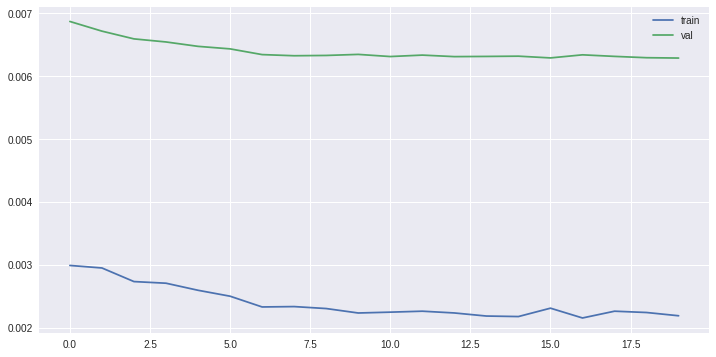

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(12, 6))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

Значение лосса падает, значит модель работает правильно.

Теперь найдём f1-score на тестовом датасете.

In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128) 

In [ ]:
probs = predict(model, test_loader)
y_preds = np.argmax(probs, axis=1)  # Метки классов предсказанные

In [ ]:
y_true = np.array(files_test['target']) # Метки классов действительные

In [ ]:
f1_score(y_true, y_preds, average='micro')

0.845

# Конечный результат.

F1-score = 0,845, что является весьма неплохим результатом. Результат можно улучшить путём увеличения количества итераций.